In [3]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, astropy, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-04-28 20:43:34 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 scipy      1.2.1
4 numpy      1.16.2
5 matplotlib 3.0.3
6 astropy    3.1.2
7 version_information 1.0.3


In [4]:
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.style.use('default')
rcParams.update({'font.size':12})

from astropy.io import fits

def expf(x, a, b):
    return a * np.exp(-b * x)

DATAPATH = Path("data")
SAVEPATH = Path("..") / "figs"

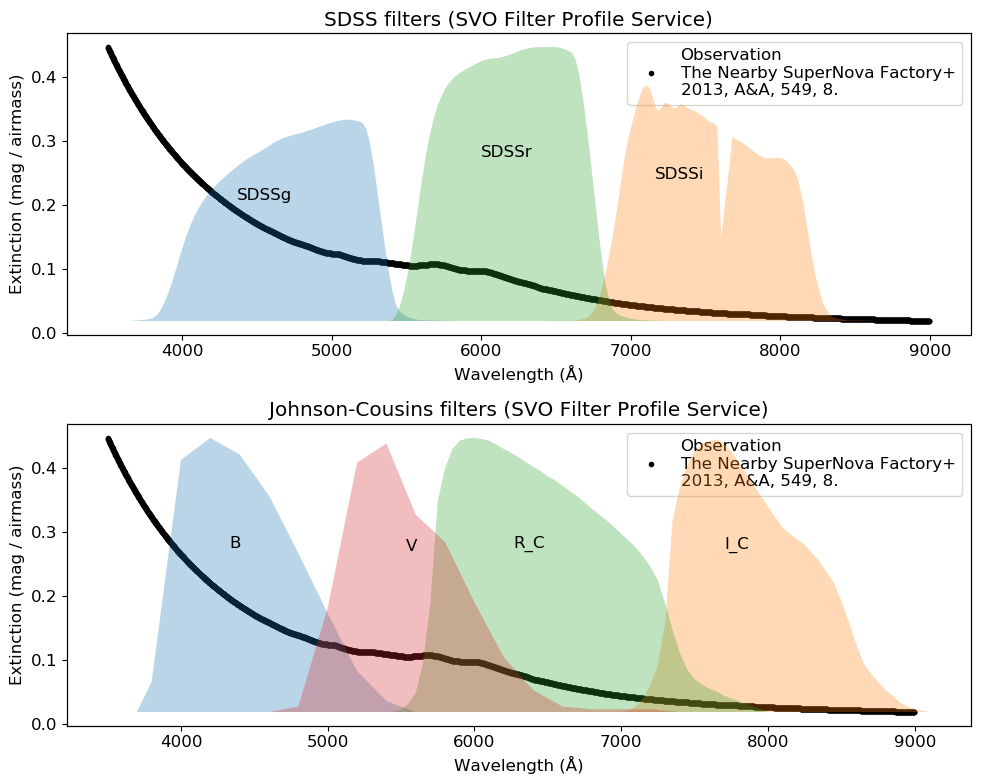

In [5]:
extdata = fits.open(DATAPATH / "SNFext.fits")

extdata[1].data = extdata[1].data[(extdata[1].data["lambda"] > 3500) & (extdata[1].data["lambda"] < 9000)]
wlen, ext = extdata[1].data["lambda"], extdata[1].data["ext"]
ww = np.linspace(3800, wlen.max(), 1000)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
twinxaxs = [axs[0].twinx(), axs[1].twinx()]
titles = ["SDSS filters (SVO Filter Profile Service)", "Johnson-Cousins filters (SVO Filter Profile Service)"]

allfilter = list(DATAPATH.glob("filter*.dat"))
allfilter.sort()
for filtpath in allfilter:
    filt = np.loadtxt(filtpath)
    filtname = filtpath.stem
    if filtname.startswith("filter_SDSS"):
        ax = twinxaxs[0]
    else:
        ax = twinxaxs[1]

    ax.fill_between(filt[:,0], filt[:,1], alpha=0.3)
    ax.text((filt[:,0].max() + 2 * filt[:,0].min()) / 3, filt[:,1].max() * 0.6, filtname.split("_", 1)[-1])
    ax.get_yaxis().set_visible(False)

for i, ax in enumerate([axs[0], axs[1]]):
    ax.plot(wlen, ext, 'k.', label="Observation\nThe Nearby SuperNova Factory+\n2013, A&A, 549, 8.")
    ax.legend()
    ax.set_xlabel(r"Wavelength (Å)")
    ax.set_ylabel("Extinction (mag / airmass)")
    ax.set_title(titles[i])

plt.tight_layout()
plt.savefig(SAVEPATH / "air-ext-and-filter.png")
plt.show()

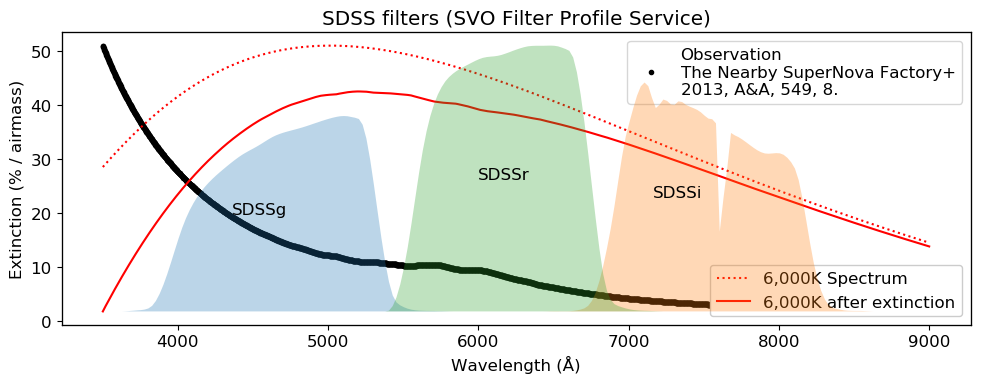

In [41]:
h = 6.62607004e-34       # Planck constant
kB = 1.38064852e-23      # Boltzman constant
c = 299792458.0          # Speed of light
sig_SB = 5.6708e-8        # Stefan-Boltzmann constant
AA = 1.e-10              # Ångstrom unit
HCK = h * c / kB

def b_lam(lam, T):
    return 2 * h * c**2 / lam**5 * 1 / (np.exp(h * c / (lam * kB * T)) - 1) / (sig_SB * T**4)

ww = np.linspace(3800, 9000, 1000)
ext_frac = 100 * (10**(0.4 * ext) - 1)  # How much % of income light is extincted.

b_sun = b_lam(wlen * AA, 5777)

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.plot(wlen, ext_frac, 'k.', label="Observation\nThe Nearby SuperNova Factory+\n2013, A&A, 549, 8.")

twinxax = axs.twinx()
twinxax.get_yaxis().set_visible(False)
twinxax.plot(wlen, b_sun, 'r:', label="6,000K Spectrum")
twinxax.plot(wlen, (1 - ext_frac / 100) * b_sun, 'r-', label="6,000K after extinction")


twinxax.legend(loc=4, framealpha=1)

axs.legend()
axs.set_xlabel(r"Wavelength (Å)")
axs.set_ylabel("Extinction (% / airmass)")
axs.set_title(titles[0])

allfilter = list(DATAPATH.glob("filter*.dat"))
allfilter.sort()
twinxax2 = axs.twinx()

for filtpath in allfilter:
    filt = np.loadtxt(filtpath)
    filtname = filtpath.stem
    if not filtname.startswith("filter_SDSS"):
        continue
    twinxax2.fill_between(filt[:,0], filt[:,1], alpha=0.3)
    twinxax2.text((filt[:,0].max() + 2 * filt[:,0].min()) / 3, filt[:,1].max() * 0.5, filtname.split("_", 1)[-1])
    twinxax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig(SAVEPATH / "air-ext-bbrad.png")

In [40]:
from scipy.interpolate import interp1d
from scipy.integrate import trapz

wlen_ext = extdata[1].data["lambda"] * AA
survived = 10**(0.4 * ext)
survived_interp = interp1d(wlen_ext, survived)


for filtpath in allfilter:
    filt = np.loadtxt(filtpath)
    filtname = filtpath.stem
    if not filtname.startswith("filter_SDSS"):
        continue
    
    print(filtname)
    
    wlen_filt = filt[:,0] * AA
    prof_filt = filt[:,1]
    dw = np.ediff1d(wlen_filt)
    surv = survived_interp(wlen_filt)  # sample extinction at filter lambdas

    for T in [3000, 6000, 20000]:
        b = b_lam(wlen_filt, T)

        flux_0   = trapz(y=b * prof_filt, x=wlen_filt * AA, dx=dw)
        flux_air = trapz(y=surv * b * prof_filt, x=wlen_filt * AA, dx=dw)
        dm = -2.5 * np.log10(flux_air / flux_0)
        print(f"{T:.0f}K: {dm:.3f}")




filter_SDSSg
3000K: -0.142
6000K: -0.158
20000K: -0.171
filter_SDSSi
3000K: -0.034
6000K: -0.035
20000K: -0.036
filter_SDSSr
3000K: -0.081
6000K: -0.084
20000K: -0.087


In [122]:
import pandas as pd

def airmass(N):
    discrete = []
    1.2 + 0.05 * np.arange(N) + 0.01 * np.random.rand(N)

np.random.seed(12345)

filters = ["g", "r"]
Nstars = 5
Nobs = 3
Nfilt = len(filters)
ids = np.arange(Nstars)
M_gs = np.array([12.0, 12.1, 12.2, 12.3, 12.5])
Cs = np.array([-0.2, +0.3, +0.5, -0.1, 0.0])

Mstars = dict(id=np.tile(np.repeat(ids, Nfilt), Nobs))
Mstars["g"] = np.tile(np.repeat(M_gs, Nfilt), Nobs)
Mstars["C"] = np.tile(np.repeat(Cs, Nfilt), Nobs)
Mstars["r"] = Mstars["g"] - Mstars["C"]
Mstars = pd.DataFrame(Mstars)

coeffs = dict(g={"z":23.1, "k":0.005, "k'":0.20, "k''":-0.016},
              r={"z":22.8, "k":0.010, "k'":0.10, "k''":-0.004})  # From SmithJA+2002AJ

tmp = np.array([0, 0.01] * (Nstars * Nobs))
X_0 = np.repeat(np.arange(Nstars * Nobs), 2)
dX_0= np.repeat(np.random.rand(Nstars * Nobs), 2)
X_g = 1.2 + 0.05 * X_0 + 0.01 * dX_0 + tmp
X_r = 1.2 + 0.05 * X_0 + 0.01 * dX_0 + tmp
f = filters * (Nstars * Nobs)

mstars = dict(g={"X":X_g}, r={"X":X_r})

for filt in ["g", "r"]:
    c = coeffs[filt]
    M = Mstars[filt]
    C = Mstars["C"]
    X = mstars[filt]["X"]
    noise = np.random.normal(0, 0.05)
    mstars[filt]["m"] = M - c["z"] - c["k"] * C + c["k'"] * X + c["k''"] * X * C + noise
    mstars[filt]["M"] = M
    mstars[filt]["id"] = Mstars["id"]

    pd.DataFrame(mstars["g"])
mstars = pd.concat([, pd.DataFrame(mstars["r"])])
Xobj = 1.4

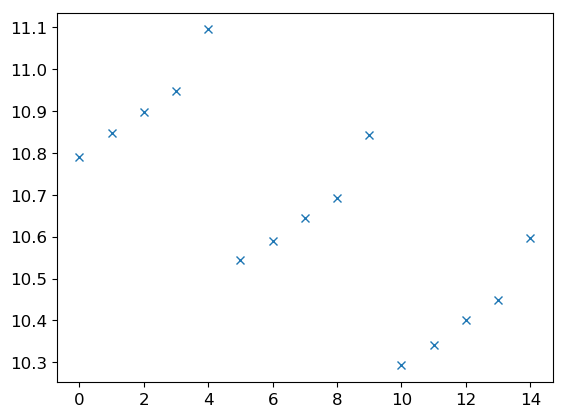

In [87]:
plt.plot(Mstars["g"] - mstars["g"], 'x')
# plt.plot(Xstars_r, 'x')

In [123]:
mstars

,X,m,M,id
0,1.209296,-10.799330,12.0,0
1,1.219296,-10.797298,12.0,0
2,1.253164,-10.702942,12.1,1
3,1.263164,-10.700990,12.1,1
4,1.301839,-10.598606,12.2,2
5,1.311839,-10.596686,12.2,2
6,1.352046,-10.472987,12.3,3
7,1.362046,-10.470971,12.3,3
8,1.405677,-10.264924,12.5,4
9,1.415677,-10.262924,12.5,4
